Tutorial: Split Simulations
=================

This tutorial demonstrates how to use the `split_simulation` tool to investigate near-field coupling effects.

Dimer nano-structure
-------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import fields
from pyGDM2 import materials
from pyGDM2 import linear
from pyGDM2 import multipole

from pyGDM2 import structures
from pyGDM2 import tools
from pyGDM2 import visu



# =============================================================================
# some global parameters
# =============================================================================
solver_method = 'lu'


## simulation environment
n3 = 1.0   # cladding layer
n2 = 1.0   # environment
n1 = 1.0   # substrate

dyads = propagators.DyadsQuasistatic123(n1, n2, n3)


# =============================================================================
# set up dielectric dimer geometry
# =============================================================================
## size of blocks
mesh = 'cube'
step = 20     # in nm

## generate two different size cuboids
geo1 = structures.rect_wire(step, L=8, H=8, W=5, mesh=mesh)
geo2 = structures.rect_wire(step, L=6,  H=8, W=3, mesh=mesh)

## move relative to each other
delta_X = 60
delta_Y = 100
geo1 = structures.shift(geo1, [-delta_X/2, -delta_Y/2, 0])
geo2 = structures.shift(geo2, [delta_X/2, delta_Y/2, 0])

## combine also the two geometries
geo_combined = structures.combine_geometries([geo1, geo2], step=step)

## instantiate structure objects: isolated block and combined blocks
material = materials.silicon()
struct_single = structures.struct(step, geo1, material)
struct_combined = structures.struct(step, geo_combined, material)


print('N dipoles full geo = {}'.format(len(geo_combined)))


# =============================================================================
# illumination: spectrum
# =============================================================================
field_generator = fields.plane_wave
wavelengths = np.linspace(500,900,31)   # nm

## ---------- Generate positions for raster-scan, aligned with structure mesh
field_kwargs = dict(inc_angle=180, E_s=1)  # 180 (deg): incident angle along -z (0deg: +z)

efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=field_kwargs)


# =============================================================================
# simulation objects
# =============================================================================
## one block isolated
sim_single = core.simulation(struct=struct_single, efield=efield, dyads=dyads)

## both blocks
sim_combined = core.simulation(struct=struct_combined, efield=efield, dyads=dyads)


structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 320/320 dipoles valid
structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 464/464 dipoles valid
N dipoles full geo = 464


Run simulations and split combined sim
--------------------------------------

We now first run both simulations (isolated block and combined structure). Then we split the combined structure to extract the cuboid corresponding to the isolated simulation. The simulated fields are copied into the splitted simulation, so we can analyze the result further and compare to the actual isolated simulation.

/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'VersionConflict((scipy 1.7.1 (/home/hans/.local/lib/python3.8/site-packages), Requirement.parse('scipy<=1.6.2,>=0.16')))'.
  entrypoints.init_all()


timing for wl=500.00nm - setup: EE 1654.7ms, inv.: 152.1ms, repropa.: 8029.2ms (1 field configs), tot: 9836.3ms
timing for wl=513.33nm - setup: EE 14.3ms, inv.: 91.9ms, repropa.: 11.9ms (1 field configs), tot: 118.3ms
timing for wl=526.67nm - setup: EE 14.4ms, inv.: 105.3ms, repropa.: 11.2ms (1 field configs), tot: 131.1ms
timing for wl=540.00nm - setup: EE 14.5ms, inv.: 96.5ms, repropa.: 11.7ms (1 field configs), tot: 122.8ms
timing for wl=553.33nm - setup: EE 14.3ms, inv.: 139.0ms, repropa.: 11.9ms (1 field configs), tot: 165.5ms
timing for wl=566.67nm - setup: EE 14.5ms, inv.: 112.9ms, repropa.: 12.2ms (1 field configs), tot: 139.8ms
timing for wl=580.00nm - setup: EE 14.1ms, inv.: 109.4ms, repropa.: 11.8ms (1 field configs), tot: 135.4ms
timing for wl=593.33nm - setup: EE 19.7ms, inv.: 98.7ms, repropa.: 11.7ms (1 field configs), tot: 130.4ms
timing for wl=606.67nm - setup: EE 19.7ms, inv.: 92.5ms, repropa.: 12.7ms (1 field configs), tot: 125.0ms
timing for wl=620.00nm - setup: EE 1

/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


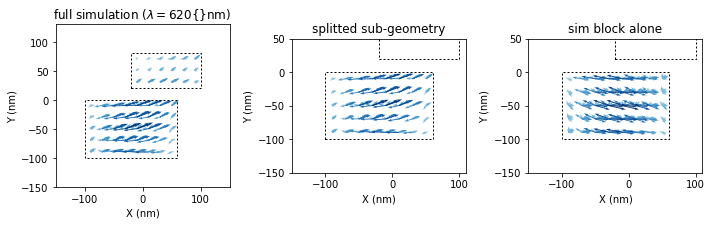

In [2]:
## run the single and combined simulations
sim_single.scatter(method=solver_method, calc_H=0)
sim_combined.scatter(method=solver_method, calc_H=0)

## remove part of geometry from combined simulation. This conserves the simulated fields
## --> the split simulation can be further evaluated to analyze the impact of near-field effects
sim_split, sim_remain = tools.split_simulation(sim_combined, geo1)


## plot the internal fields at a selected wavelength
fidx = tools.get_closest_field_index(sim_single, dict(wavelength=620))

plt.figure(figsize=(10,4))
plt.subplot(131)
plt.title(r"full simulation ($\lambda=620${}nm)")
visu.vectorfield_by_fieldindex(sim_combined, field_index=fidx, show=0, projection='XY')
visu.structure_contour(sim_combined, color='k', dashes=[2,2], show=0)

plt.subplot(132)
plt.title("splitted sub-geometry")
visu.vectorfield_by_fieldindex(sim_split, field_index=fidx, show=0, projection='XY')
visu.structure_contour(sim_combined, color='k', dashes=[2,2], show=0)

plt.subplot(133)
plt.title("sim block alone")
visu.vectorfield_by_fieldindex(sim_single, field_index=fidx, show=0, projection='XY')
visu.structure_contour(sim_combined, color='k', dashes=[2,2], show=0)

plt.tight_layout()
plt.show()

Plot the spectra
----------------------------

We now compare the spectra of the isolated simulation and the block split from the combined simulation

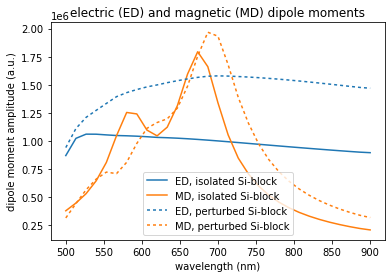

In [4]:
wl, specext = tools.calculate_spectrum(sim_single, 0, multipole.multipole_decomposition_exact, which_moments=['p', 'm'])
p, m = specext[:,0,:], specext[:,1,:]
wl, specext = tools.calculate_spectrum(sim_combined, 0, multipole.multipole_decomposition_exact, which_moments=['p', 'm'])
p_c, m_c = specext[:,0,:], specext[:,1,:]


plt.title("electric (ED) and magnetic (MD) dipole moments")
plt.plot(wl, np.linalg.norm(p, axis=1), color='C0', label='ED, isolated Si-block')
plt.plot(wl, np.linalg.norm(m, axis=1), color='C1', label='MD, isolated Si-block')

plt.plot(wl, np.linalg.norm(p_c, axis=1), color='C0', dashes=[2,2], label='ED, perturbed Si-block')
plt.plot(wl, np.linalg.norm(m_c, axis=1), color='C1', dashes=[2,2], label='MD, perturbed Si-block')

plt.legend()
plt.xlabel('wavelength (nm)')
plt.ylabel('dipole moment amplitude (a.u.)')

plt.show()

We find that the neighbor structure has mainly a qualitative impact on the magnetic dipole response of the silicon block, while the electric dipole response remais qualitatively similar. Yet, the indiced electric dipole moment is stronger if the near-field coupling is included.